In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import alexnet
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [2]:
mpl.rcParams['figure.dpi'] = 300
sns.set_theme()
sns.set_style("ticks")

# Training

## Setup

In [40]:
# Inputs

df_train_path = 'df_train.csv'
df_val_path  = 'df_val.csv'
df_test_path  = 'df_test.csv'
distort_img_path = 'distorted_crosswalk_images_crop'
num_epochs_for_today = 10
checkpoint_path = 'AlexNet_cuda_weights/AlexNet_ClassReg_Checkpoint.pth.tar'

In [41]:
df_train_full = pd.read_csv(df_train_path)
df_val_full = pd.read_csv(df_val_path)
df_test_full = pd.read_csv(df_test_path)

df_train = df_train_full[["id2","level","k"]]
df_val = df_val_full[["id2","level","k"]]
df_test = df_test_full[["id2","level","k"]]
df_test_with_id1 = df_test_full[["id1","id2","level"]]

In [42]:
# Define the Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the Custom Dataset Class
class CrosswayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 0]) + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        k_value = float(self.dataframe.iloc[idx, 2])  # New line to extract the "k" value
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, k_value  # Return the image, label, and k_value
    
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch']
    return start_epoch

In [43]:
# Create Dataset Objects and DataLoaders
train_dataset = CrosswayDataset(dataframe=df_train, root_dir=distort_img_path, transform=transform)
val_dataset = CrosswayDataset(dataframe=df_val, root_dir=distort_img_path, transform=transform)
test_dataset = CrosswayDataset(dataframe=df_test, root_dir=distort_img_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Begin training

In [39]:
# Generate k_list using NumPy
k_list = np.linspace(1e-6, 1e-4, 100)

# Convert k_list to a PyTorch tensor
k_list_tensor = torch.tensor(k_list, dtype=torch.float32)

# Calculate k_means as the average of adjacent elements in k_list
k_means_np = (k_list[1:] + k_list[:-1]) / 2

# Convert k_means to a PyTorch tensor
k_means = torch.tensor(k_means_np, dtype=torch.float32)

def get_k_preds(level_preds, k_means, k_gts, device):
    # Convert logits to probabilities using softmax
    probabilities = F.softmax(level_preds, dim=1)
    
    # print(probabilities)
    
    # Ensure X is on the correct device
    k_means = k_means.to(device)
    
    # Perform the dot product between probabilities and X
    k_preds = torch.matmul(probabilities, k_means).unsqueeze(1)
    
    # Ensure the output dimension matches k_gts
    # Assuming k_gts has shape [batch_size, target_dimension]
    # The resulting outputs_k_gt should have the same shape as k_gts
    
#     print(f"k_preds.shape ={k_preds.shape}")
#     print(f"k_gts.shape ={k_gts.shape}")
    assert k_preds.shape == k_gts.shape, "Shape mismatch between outputs_k_gt and k_gts"

    return k_preds

In [16]:
# Load the pretrained AlexNet model
model = alexnet(pretrained=True)

# Modify the classifier to output 99 classes
model.classifier[-1] = nn.Linear(in_features=4096, out_features=99)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Add this line to check if GPU is being used

model.to(device)

# Loss function and optimizer
criterionCE = nn.CrossEntropyLoss()
criterionMSE = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path)
    print(f"Resuming training from epoch {start_epoch + 1}")
else:
    start_epoch = 0

# Training loop
num_epochs = start_epoch + num_epochs_for_today

training_loss_list = []
validation_loss_list = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training phase
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for images, level_gts, k_gts in progress_bar:
        images = images.to(device)
        level_gts = level_gts.to(device)
        k_gts = k_gts.to(device).float().view(-1, 1)

        # Forward pass
        level_preds = model(images)
        k_preds = get_k_preds(level_preds, k_means, k_gts, device)
        
        loss = criterionCE(level_preds, level_gts) + criterionMSE(k_preds, k_gts)*1e11

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        # Update the progress bar
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataset)
    training_loss_list.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        for images, level_gts, k_gts in progress_bar:
            images = images.to(device)
            level_gts = level_gts.to(device)
            k_gts = k_gts.to(device).float().view(-1, 1)


            # Forward pass
            level_preds = model(images)
            k_preds = get_k_preds(level_preds, k_means, k_gts, device)
            
            loss = criterionCE(level_preds, level_gts) + criterionMSE(k_preds, k_gts)*1e10
            val_loss += loss.item() * images.size(0)
            
            # Update the progress bar
            progress_bar.set_postfix(loss=loss.item())
    
    val_loss /= len(val_dataset)
    validation_loss_list.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Loss: {val_loss:.4f}')
    
    # Save the model and optimizer states for this epoch
    checkpoint = {
        'epoch': epoch + 1,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Save the model weights separately for this epoch
    model_save_path = os.path.join(f'AlexNet_cuda_weights/classreg/alexnet_classreg_epoch_{epoch}.pth') #############################################
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')

Using device: cuda
Resuming training from epoch 21


Epoch [21/30] Training Loss: 1.7594


Epoch [21/30] Validation Loss: 1.8911
Checkpoint saved at epoch 21
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_21.pth


Epoch [22/30] Training Loss: 1.7151


Epoch [22/30] Validation Loss: 1.9652
Checkpoint saved at epoch 22
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_22.pth


Epoch [23/30] Training Loss: 1.6731


Epoch [23/30] Validation Loss: 1.9558
Checkpoint saved at epoch 23
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_23.pth


Epoch [24/30] Training Loss: 1.6311


Epoch [24/30] Validation Loss: 1.9564
Checkpoint saved at epoch 24
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_24.pth


Epoch [25/30] Training Loss: 1.6042


Epoch [25/30] Validation Loss: 1.9920
Checkpoint saved at epoch 25
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_25.pth


Epoch [26/30] Training Loss: 1.5640


Epoch [26/30] Validation Loss: 1.9483
Checkpoint saved at epoch 26
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_26.pth


Epoch [27/30] Training Loss: 1.5335


Epoch [27/30] Validation Loss: 1.9883
Checkpoint saved at epoch 27
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_27.pth


Epoch [28/30] Training Loss: 1.4950


Epoch [28/30] Validation Loss: 2.0234
Checkpoint saved at epoch 28
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_28.pth


Epoch [29/30] Training Loss: 1.4765


Epoch [29/30] Validation Loss: 1.9881
Checkpoint saved at epoch 29
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_29.pth


Epoch [30/30] Training Loss: 1.4493


Epoch [30/30] Validation Loss: 2.1625
Checkpoint saved at epoch 30
Model saved to AlexNet_weights/classreg/alexnet_classreg_epoch_30.pth


In [17]:
training_loss_list

[1.7594259771192917,
 1.715076392925147,
 1.6731156857808431,
 1.6310578087604408,
 1.6041700078983498,
 1.5639688139732437,
 1.5334524374297172,
 1.494950254156132,
 1.4764579452167859,
 1.4493093933721986]

In [18]:
validation_loss_list

[1.891087046777359,
 1.9652286590229382,
 1.9557826803669784,
 1.956366958858991,
 1.992011159453729,
 1.948330698832117,
 1.9882703863490712,
 2.023396417637064,
 1.9881276339232319,
 2.162480275077049]

# Inference

In [44]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the pretrained AlexNet model
model = alexnet(pretrained=True)

# Modify the classifier to output 18 classes
model.classifier[-1] = nn.Linear(in_features=4096, out_features=99)

# Load the model weights
model_path = 'AlexNet_cuda_weights/classreg/alexnet_classreg_epoch_22.pth'  ############# Select your trained model weights
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

Using device: cuda


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Testing on 1 image

In [45]:
# Define the image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to perform inference and get probabilities
def predict_image(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities.cpu().numpy().flatten()

In [46]:
# Path to the image you want to infer
test_img_path = os.path.join(distort_img_path, str(df_test.iloc[0, 0]) + '.jpg')

# Perform inference
predicted_class, probabilities = predict_image(test_img_path, model, transform, device)

# Print the predicted class and probabilities
print(f'Ground truth class: {df_test.iloc[0,1]}')
print(f'Predicted class: {predicted_class}')
print(f'Probabilities for each class: {probabilities}')

Ground truth class: 76
Predicted class: 72
Probabilities for each class: [1.90436222e-09 1.32750727e-10 5.36980960e-10 6.70735065e-11
 1.44975670e-10 1.31062078e-10 9.40541325e-11 4.75269685e-11
 7.43704612e-11 2.07863823e-10 9.54638799e-11 7.44783402e-11
 3.16168369e-10 1.01931165e-10 2.05520129e-10 1.63117159e-10
 3.60883302e-11 9.67433147e-11 1.07519577e-10 2.66141310e-11
 5.05752107e-11 8.12433662e-11 1.32743122e-10 6.77403897e-11
 7.18391041e-11 6.54881496e-11 5.98949293e-11 2.28666669e-11
 2.13298563e-11 4.15550094e-11 5.16046025e-11 5.87339899e-11
 3.52577932e-11 3.82599265e-11 4.14196143e-11 2.28328918e-11
 4.69951031e-12 1.42551118e-11 6.71339828e-13 1.88608542e-13
 1.60952916e-13 1.83844774e-14 7.79587356e-15 1.68531452e-14
 6.14288368e-15 2.03569410e-14 1.13739965e-14 5.27394371e-16
 4.72075212e-14 5.09113123e-16 8.21532258e-15 8.00504835e-15
 8.57678711e-15 9.75033686e-15 3.06657585e-15 2.94479881e-14
 5.66323603e-15 5.31858368e-12 3.21357281e-11 8.14734565e-12
 9.54881396e

## Testing on `test_loader`

### Predicted levels, Predicted k, Percentage error

In [47]:
test_loader

In [48]:
# Given array
k_list = np.linspace(1e-6, 1e-4, 100)

# Initialize a list to store the averages
k_mean = []

# Loop through the array starting from the second element
for i in range(1, len(k_list)):
    mean = (k_list[i] + k_list[i-1]) / 2
    k_mean.append(mean)

# Convert the list to a numpy array (optional)
k_mean = np.array(k_mean)

print(k_mean)

[1.50e-06 2.50e-06 3.50e-06 4.50e-06 5.50e-06 6.50e-06 7.50e-06 8.50e-06
 9.50e-06 1.05e-05 1.15e-05 1.25e-05 1.35e-05 1.45e-05 1.55e-05 1.65e-05
 1.75e-05 1.85e-05 1.95e-05 2.05e-05 2.15e-05 2.25e-05 2.35e-05 2.45e-05
 2.55e-05 2.65e-05 2.75e-05 2.85e-05 2.95e-05 3.05e-05 3.15e-05 3.25e-05
 3.35e-05 3.45e-05 3.55e-05 3.65e-05 3.75e-05 3.85e-05 3.95e-05 4.05e-05
 4.15e-05 4.25e-05 4.35e-05 4.45e-05 4.55e-05 4.65e-05 4.75e-05 4.85e-05
 4.95e-05 5.05e-05 5.15e-05 5.25e-05 5.35e-05 5.45e-05 5.55e-05 5.65e-05
 5.75e-05 5.85e-05 5.95e-05 6.05e-05 6.15e-05 6.25e-05 6.35e-05 6.45e-05
 6.55e-05 6.65e-05 6.75e-05 6.85e-05 6.95e-05 7.05e-05 7.15e-05 7.25e-05
 7.35e-05 7.45e-05 7.55e-05 7.65e-05 7.75e-05 7.85e-05 7.95e-05 8.05e-05
 8.15e-05 8.25e-05 8.35e-05 8.45e-05 8.55e-05 8.65e-05 8.75e-05 8.85e-05
 8.95e-05 9.05e-05 9.15e-05 9.25e-05 9.35e-05 9.45e-05 9.55e-05 9.65e-05
 9.75e-05 9.85e-05 9.95e-05]


In [49]:
# Assuming the model is already loaded and test_dataset is defined
model.eval()

# Initialize lists to store true labels, predictions, and k predictions
all_labels = []
all_preds = []
all_k_preds = []

# Inference on the test dataset
with torch.no_grad():
    for images, level_gts, k_gts in test_loader:
        images = images.to(device)
        level_gts = level_gts.to(device)
        k_gts = k_gts.to(device).float().view(-1, 1)


        outputs = model(images)
        
        # Compute probabilities using softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

        # Predict class with max probability
        _, preds = torch.max(outputs, 1)

        # Compute k_predictions using np.dot(k_mean, probabilities) for each image
        k_preds = np.dot(probabilities, k_mean)

        all_labels.extend(level_gts.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_k_preds.extend(k_preds)

In [50]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_k_preds = np.array(all_k_preds)

In [51]:
df_test_report = df_test_with_id1.copy(deep=True)
df_test_report["level_preds"] = all_preds
df_test_report["k_gt"] = df_test_full["k"]
df_test_report["k_preds"] = all_k_preds

In [52]:
# Calculate the percentage error for each row
df_test_report['percentage_error'] = 100 * abs(df_test_report['k_gt'] - df_test_report['k_preds']) / df_test_report['k_gt']

# Compute the average percentage error across all rows
average_percentage_error = df_test_report['percentage_error'].mean()

print("average_percentage_error =", average_percentage_error)

df_test_report.to_csv('df_test_report_classreg.csv', index=False)

df_test_report

average_percentage_error = 4.389089774101484


,id1,id2,level,level_preds,k_gt,k_preds,percentage_error
0,1000673,2066703,76,72,0.000078,0.000074,4.819882
1,1000756,2074905,61,63,0.000062,0.000064,3.033108
2,1000222,2022038,60,62,0.000061,0.000064,5.043041
3,1000612,2060686,98,92,0.000100,0.000092,8.315141
4,1000041,2004094,35,36,0.000036,0.000037,3.151521
...,...,...,...,...,...,...,...
9895,1000220,2021815,35,36,0.000037,0.000037,1.042848
9896,1000661,2065463,24,24,0.000025,0.000025,0.935780
9897,1000118,2011739,57,55,0.000058,0.000056,3.777710
9898,1000182,2018046,28,30,0.000030,0.000032,5.578436


### Classification Report, Confusion Matrix

In [53]:
# Assuming all_labels and all_preds are your true labels and predicted labels
class_report = classification_report(all_labels, all_preds, digits=4, output_dict=True)

# Convert the dictionary to a DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

class_report_df.to_csv('df_test_class_report_classreg.csv', index=False)

# Display the DataFrame
class_report_df

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.484472,0.78000,0.597701,100.00000
1,0.413793,0.12000,0.186047,100.00000
2,0.400000,0.50000,0.444444,100.00000
3,0.493333,0.37000,0.422857,100.00000
4,0.482143,0.54000,0.509434,100.00000
...,...,...,...,...
97,0.141104,0.23000,0.174905,100.00000
98,0.303030,0.10000,0.150376,100.00000
accuracy,0.292020,0.29202,0.292020,0.29202
macro avg,0.286190,0.29202,0.270253,9900.00000


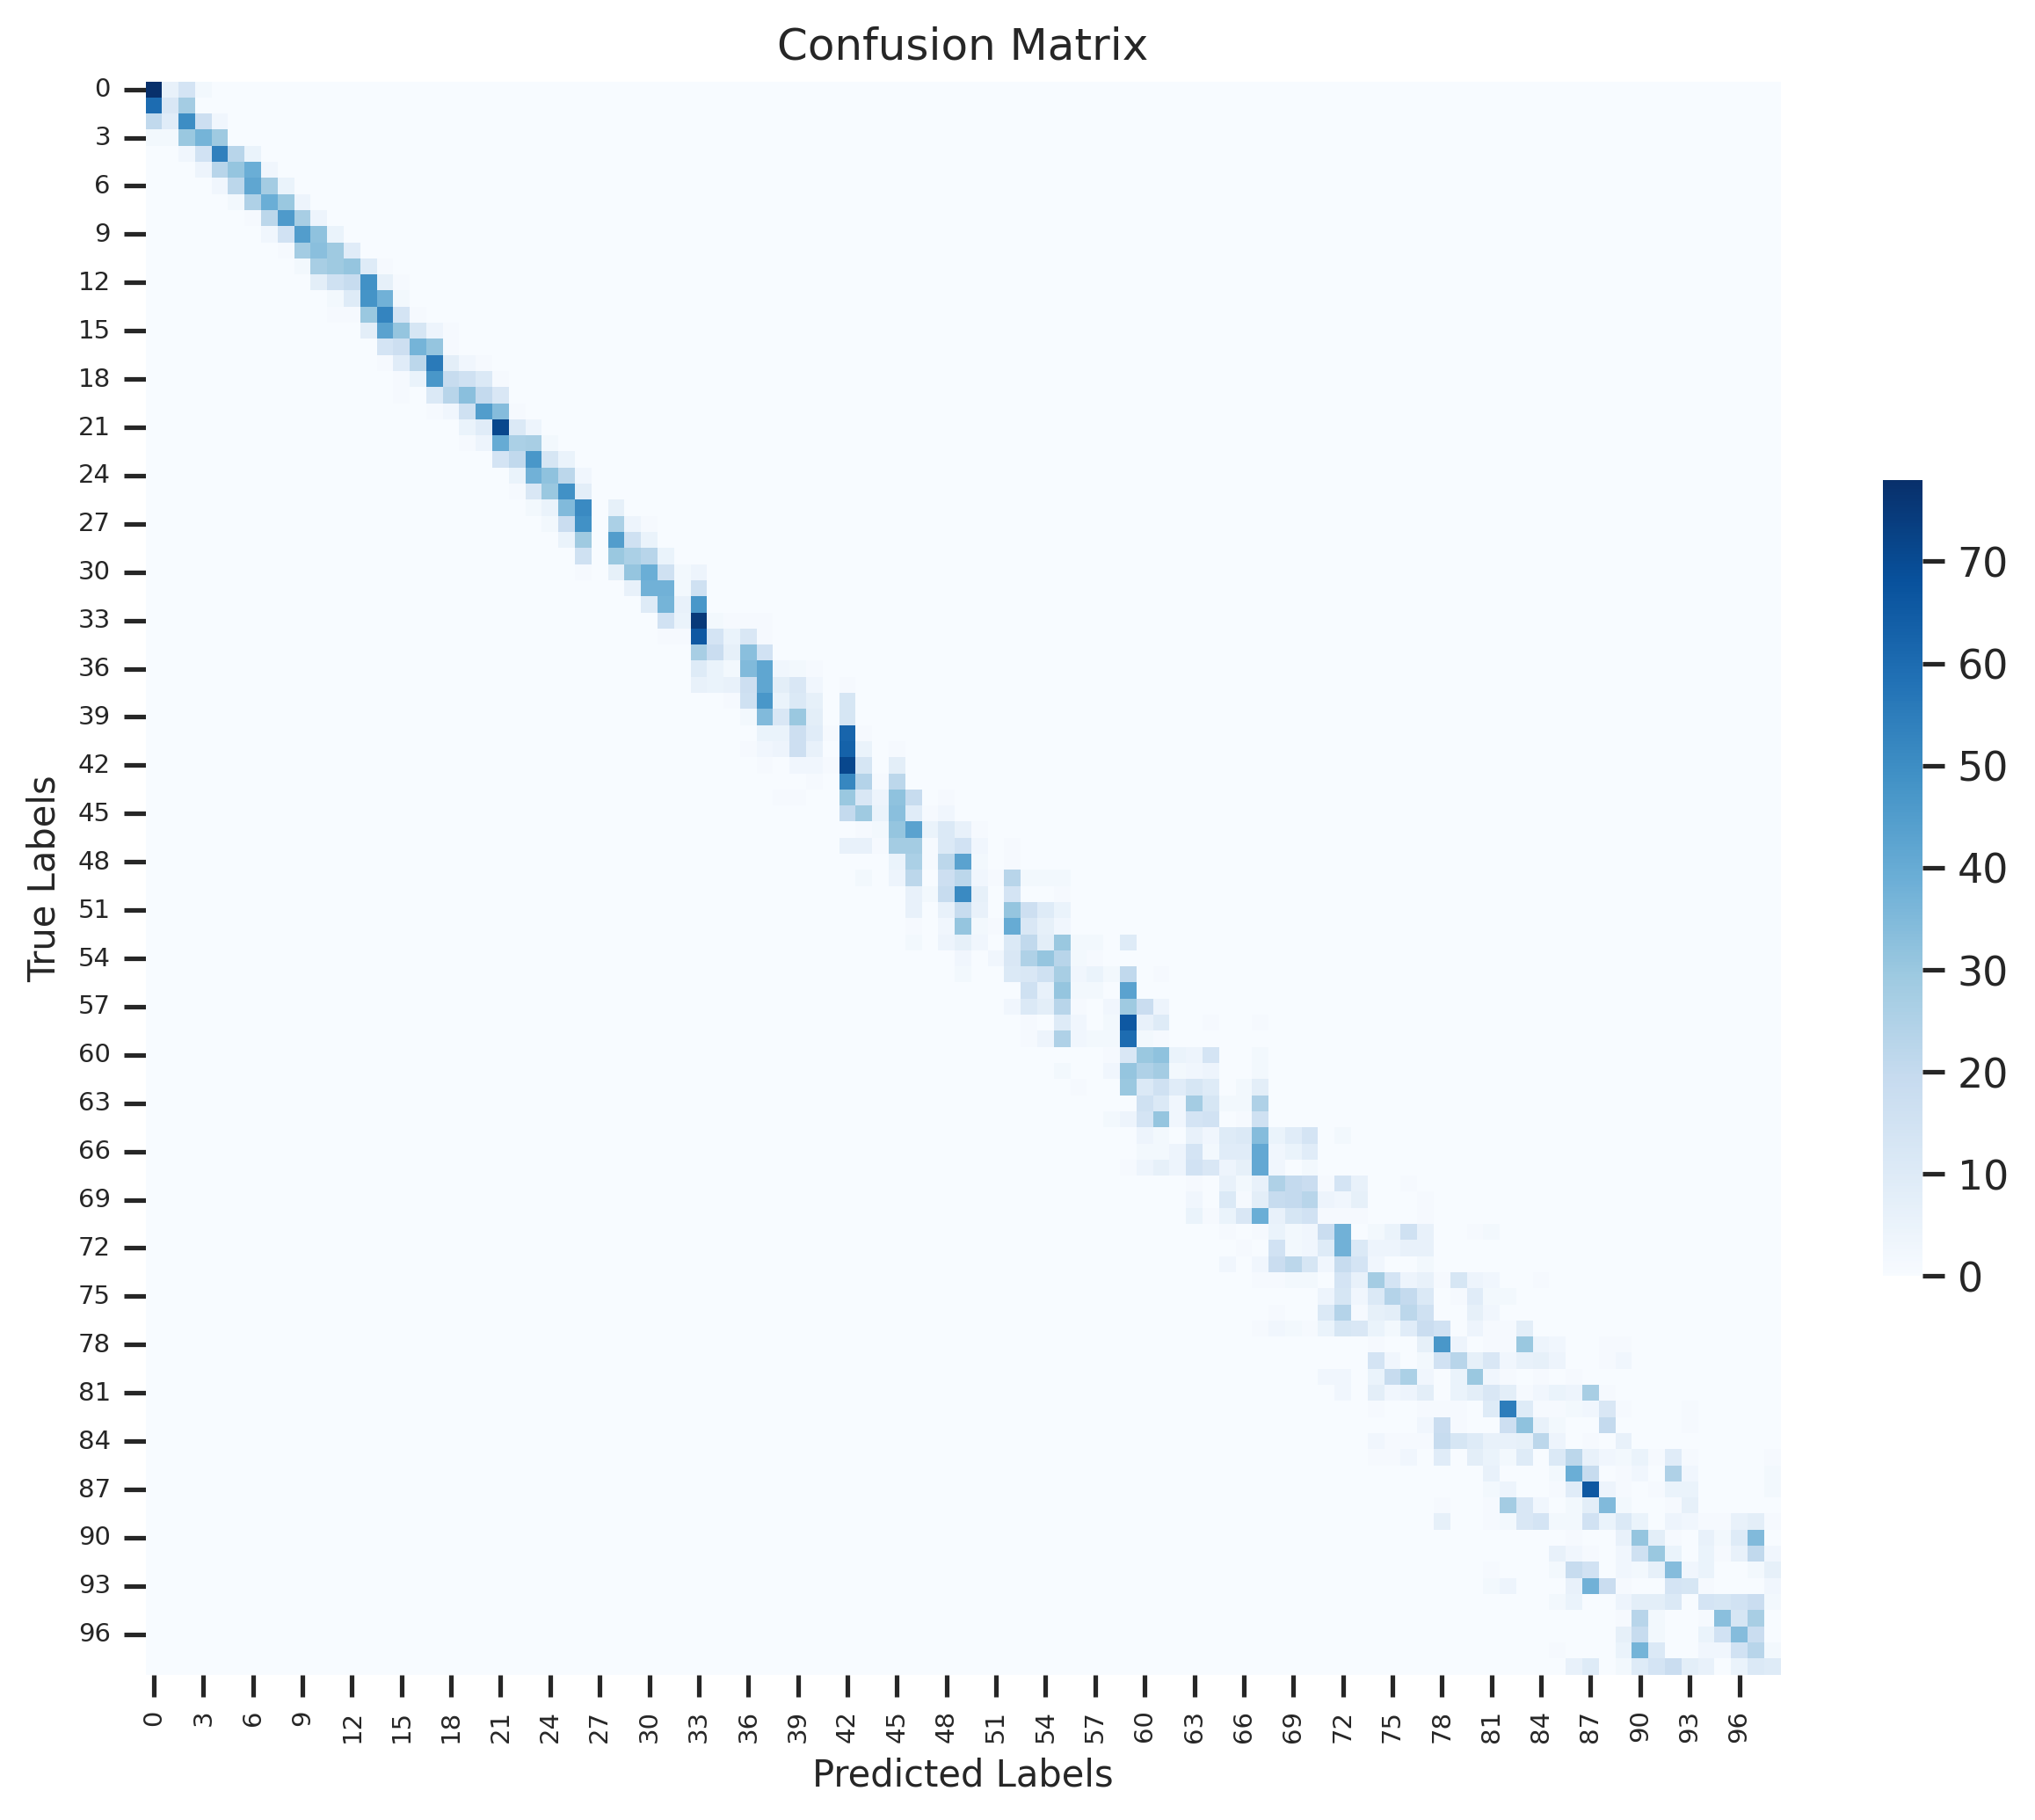

In [54]:
# Assuming all_labels and all_preds are your true labels and predicted labels
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))

# Create the heatmap with no annotations and add color bar on the right
sns.heatmap(conf_matrix, annot=False, cmap='Blues', cbar=True, cbar_kws={"shrink": 0.5})

# Set the title and labels with reduced font sizes
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=10)
plt.ylabel('True Labels', fontsize=10)

# Ensure tick labels are visible with reduced font size
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

### All at once

In [30]:
# Given array
k_list = np.linspace(1e-6, 1e-4, 100)

# Initialize a list to store the averages
k_mean = []

# Loop through the array starting from the second element
for i in range(1, len(k_list)):
    mean = (k_list[i] + k_list[i-1]) / 2
    k_mean.append(mean)

# Convert the list to a numpy array (optional)
k_mean = np.array(k_mean)

print(k_mean)

[1.50e-06 2.50e-06 3.50e-06 4.50e-06 5.50e-06 6.50e-06 7.50e-06 8.50e-06
 9.50e-06 1.05e-05 1.15e-05 1.25e-05 1.35e-05 1.45e-05 1.55e-05 1.65e-05
 1.75e-05 1.85e-05 1.95e-05 2.05e-05 2.15e-05 2.25e-05 2.35e-05 2.45e-05
 2.55e-05 2.65e-05 2.75e-05 2.85e-05 2.95e-05 3.05e-05 3.15e-05 3.25e-05
 3.35e-05 3.45e-05 3.55e-05 3.65e-05 3.75e-05 3.85e-05 3.95e-05 4.05e-05
 4.15e-05 4.25e-05 4.35e-05 4.45e-05 4.55e-05 4.65e-05 4.75e-05 4.85e-05
 4.95e-05 5.05e-05 5.15e-05 5.25e-05 5.35e-05 5.45e-05 5.55e-05 5.65e-05
 5.75e-05 5.85e-05 5.95e-05 6.05e-05 6.15e-05 6.25e-05 6.35e-05 6.45e-05
 6.55e-05 6.65e-05 6.75e-05 6.85e-05 6.95e-05 7.05e-05 7.15e-05 7.25e-05
 7.35e-05 7.45e-05 7.55e-05 7.65e-05 7.75e-05 7.85e-05 7.95e-05 8.05e-05
 8.15e-05 8.25e-05 8.35e-05 8.45e-05 8.55e-05 8.65e-05 8.75e-05 8.85e-05
 8.95e-05 9.05e-05 9.15e-05 9.25e-05 9.35e-05 9.45e-05 9.55e-05 9.65e-05
 9.75e-05 9.85e-05 9.95e-05]


In [31]:
# Define the image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to perform inference and get probabilities
def predict_image(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities.cpu().numpy().flatten()

def all_at_once(model_path):
    
    # Define the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load the pretrained AlexNet model
    model = alexnet(pretrained=True)

    # Modify the classifier to output 18 classes
    model.classifier[-1] = nn.Linear(in_features=4096, out_features=99)

    # Load the model weights
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # Initialize lists to store true labels, predictions, and k predictions
    all_labels = []
    all_preds = []
    all_k_preds = []

    with torch.no_grad():
        for images, level_gts, k_gts in test_loader:
            images = images.to(device)
            level_gts = level_gts.to(device)
            k_gts = k_gts.to(device).float().view(-1, 1)


            outputs = model(images)

            # Compute probabilities using softmax
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

            # Predict class with max probability
            _, preds = torch.max(outputs, 1)

            # Compute k_predictions using np.dot(k_mean, probabilities) for each image
            k_preds = np.dot(probabilities, k_mean)

            all_labels.extend(level_gts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_k_preds.extend(k_preds)
    
    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_k_preds = np.array(all_k_preds)
    df_test_report = df_test.copy(deep=True)
    df_test_report["level_preds"] = all_preds
    df_test_report["k_gt"] = df_test_full["k"]
    df_test_report["k_preds"] = all_k_preds
    df_test_report['percentage_error'] = 100 * abs(df_test_report['k_gt'] - df_test_report['k_preds']) / df_test_report['k_gt']

    # Compute the average percentage error across all rows
    average_percentage_error = df_test_report['percentage_error'].mean()

    return round(average_percentage_error,4)

In [32]:
average_percentage_error_list = []

for i in range(0,30):
    model_path = f"AlexNet_cuda_weights/classreg/alexnet_classreg_epoch_{i}.pth"
    average_percentage_error = all_at_once(model_path)
    average_percentage_error_list.append(average_percentage_error)
    print(f"Epoch {i}: average_percentage_error = {average_percentage_error}")

average_percentage_error_list

Using device: cuda


/usr/local/lib64/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib64/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: average_percentage_error = 6.5668
Using device: cuda
Epoch 1: average_percentage_error = 9.3945
Using device: cuda
Epoch 2: average_percentage_error = 7.7976
Using device: cuda
Epoch 3: average_percentage_error = 6.0817
Using device: cuda
Epoch 4: average_percentage_error = 6.5522
Using device: cuda
Epoch 5: average_percentage_error = 5.9065
Using device: cuda
Epoch 6: average_percentage_error = 5.6413
Using device: cuda
Epoch 7: average_percentage_error = 5.545
Using device: cuda
Epoch 8: average_percentage_error = 5.202
Using device: cuda
Epoch 9: average_percentage_error = 5.0876
Using device: cuda
Epoch 10: average_percentage_error = 4.8597
Using device: cuda
Epoch 11: average_percentage_error = 5.2407
Using device: cuda
Epoch 12: average_percentage_error = 5.1105
Using device: cuda
Epoch 13: average_percentage_error = 5.0477
Using device: cuda
Epoch 14: average_percentage_error = 4.6326
Using device: cuda
Epoch 15: average_percentage_error = 4.7596
Using device: cuda
Epoc

[6.5668,
 9.3945,
 7.7976,
 6.0817,
 6.5522,
 5.9065,
 5.6413,
 5.545,
 5.202,
 5.0876,
 4.8597,
 5.2407,
 5.1105,
 5.0477,
 4.6326,
 4.7596,
 4.5283,
 4.5637,
 5.0742,
 4.6679,
 4.493,
 4.6175,
 4.3891,
 4.4398,
 4.5786,
 4.587,
 4.3427,
 4.5865,
 4.4693,
 4.7735]